In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
import datetime as dt
from math import factorial

metrics_path = '../metrics/'
figure_path = 'figures/'

def get_filenames_in_folder(path):
    file_names = [join(path, f) for f in listdir(path) if isfile(join(path, f)) and f.lower().endswith('.csv')]
    file_names.sort()
    return file_names

all_files = get_filenames_in_folder(metrics_path)
print(all_files)

def read_file(path):
    return pd.read_csv(path, comment='#')

if len(all_files) > 0:
    latest_data = read_file(all_files[0])
    print(latest_data.iloc[1])

GLOBAL_STYLE = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],
    'font.size': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'axes.axisbelow': True  # grid lines below data
}

FIGURE_SIZE = (12, 7)

LINE_STYLE = {
    "linewidth": 1.5,
    "linestyle": "-"  # solid lines
}

GRID_STYLE = {
    "visible": True,
    "linestyle": "--",
    "alpha": 0.6
}

plt.rcParams.update(GLOBAL_STYLE)

['../metrics/2025-07-31_10-12-42_metrics.csv', '../metrics/2025-08-04_13-15-09_metrics.csv', '../metrics/2025-08-04_16-11-57_metrics.csv', '../metrics/2025-08-04_16-14-45_metrics.csv', '../metrics/2025-08-04_16-15-33_metrics.csv', '../metrics/2025-08-04_16-17-37_metrics.csv']
timestamp    2025-07-31T10:08:36+00:00
field                   fragments_sent
value                              0.0
node                            node_0
Name: 1, dtype: object


[0.003   0.00475 0.0065  0.00825 0.01   ]
[41.02993774 32.00982809 27.97885021 25.58615414 24.06298621]
[0.42050925 0.26617291 0.19375441 0.15176312 0.12437095]
5
[np.float64(97.57202219963074), np.float64(120.25952553749084), np.float64(144.4036796092987), np.float64(168.5927028656006), np.float64(193.47755241394043)]


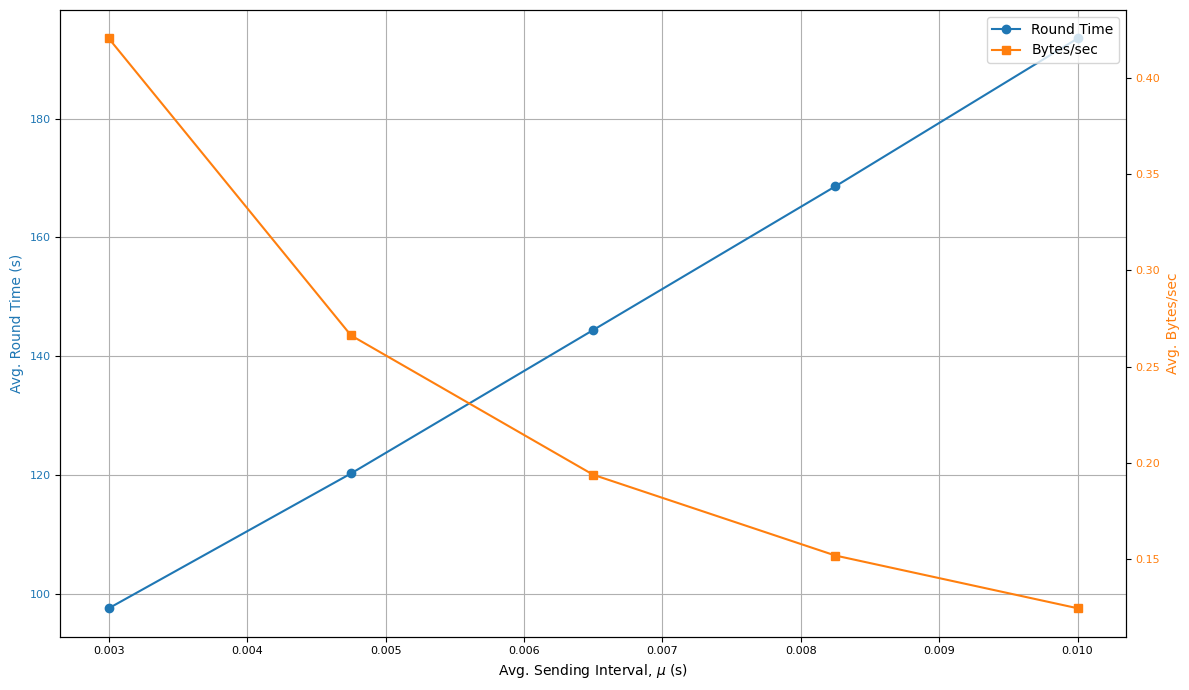

In [2]:
# Time per scenario
# 10 rounds
# y: time per whole scenario
# x: delay in seconds

mus = np.linspace(0.003, 0.01, num=5)
print(mus)

rt_files = get_filenames_in_folder(join(metrics_path, "run_time"))

def deserizalize_time(str_time):
    return dt.datetime.fromisoformat(str_time)

def get_duration(df):
    filtered_df = df.loc[df['field'] == "round_time"]
    return filtered_df['value'].max()

def get_total_msgbytes(df):
    return df[df['field'] == "total_mbytes_sent"].groupby('node')['value'].max().mean()

df_rt_files = [read_file(f) for f in rt_files]
rt_list = [get_duration(df) for df in df_rt_files]
bytes_list = np.array([get_total_msgbytes(df) for df in df_rt_files])
print(bytes_list)
bytes_s = bytes_list / rt_list
print(bytes_s)
print(len(rt_list))
print(rt_list)

fig, ax1 = plt.subplots(figsize=FIGURE_SIZE)

# First y-axis: Scenario time
ax1.plot(mus[:len(rt_list)], rt_list, marker='o', color='tab:blue', label='Round Time')
ax1.set_xlabel('Avg. Sending Interval, $\\mu$ (s)')
ax1.set_ylabel('Avg. Round Time (s)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Second y-axis: Bytes per second
ax2 = ax1.twinx()
ax2.plot(mus[:len(bytes_s)], bytes_s, marker='s', color='tab:orange', label='Bytes/sec')
ax2.set_ylabel('Avg. Bytes/sec', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add grid only on primary axis
ax1.grid(True)
fig.tight_layout()

# Optional: Add a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Save and show
plt.savefig(join(figure_path, "time-and-bytes-per-scenario.png"))
plt.show()


[29.50428495 20.81866753 18.38546127 18.71263075 17.89216677 18.12382731]
[17.0646713  18.53267583 19.24790607 19.05224518]


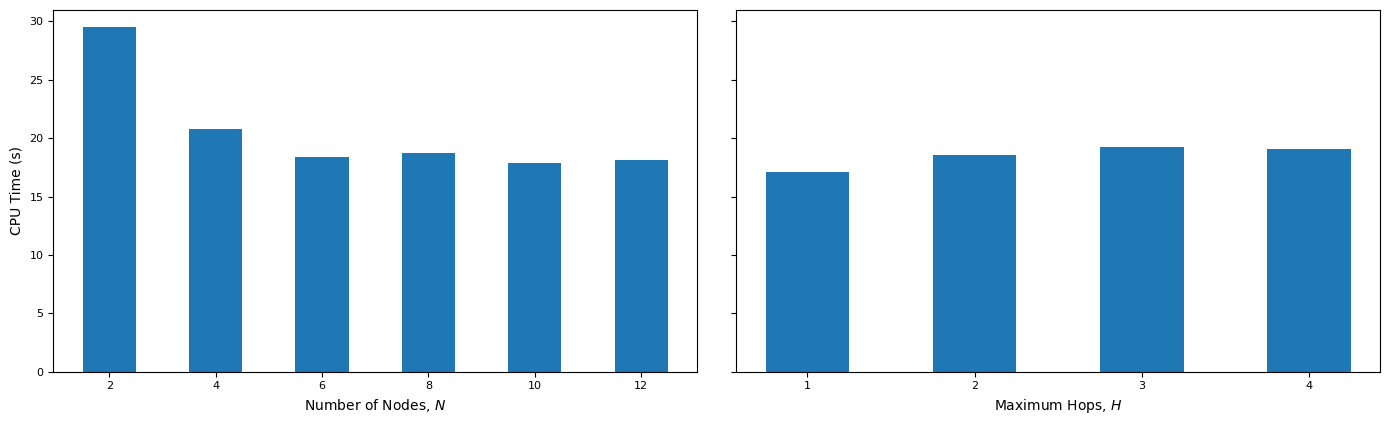

[590.6771875  590.3075     584.18045455 582.30193182 595.98851111
 590.19097222]
[571.85603704 582.37766667 584.01473485 589.24038462]


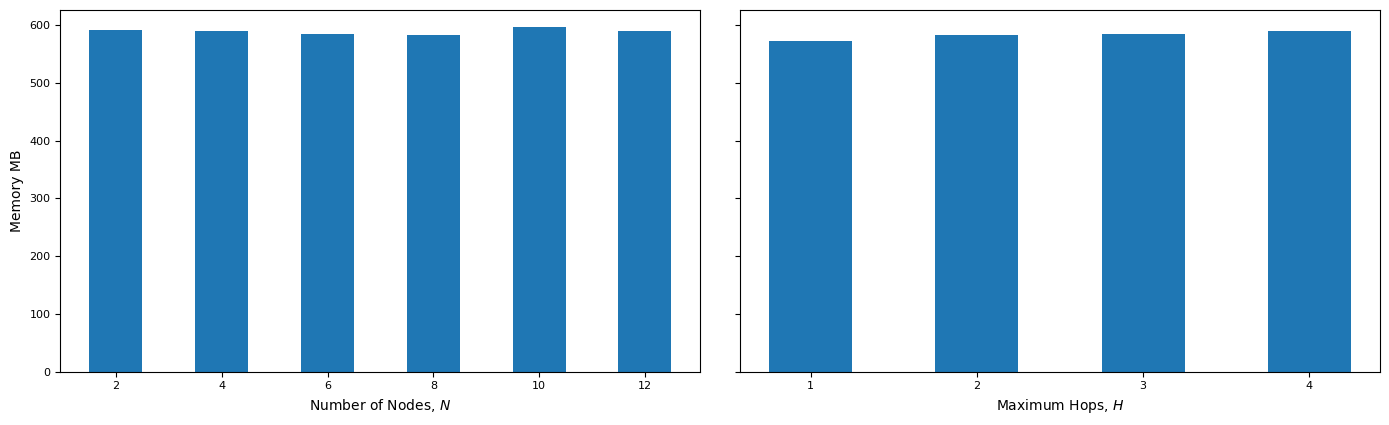

[ 96.116764 123.65735  150.774156 187.027876 213.216574 242.552789]
[132.843584 151.722482 168.375237 187.3918  ]


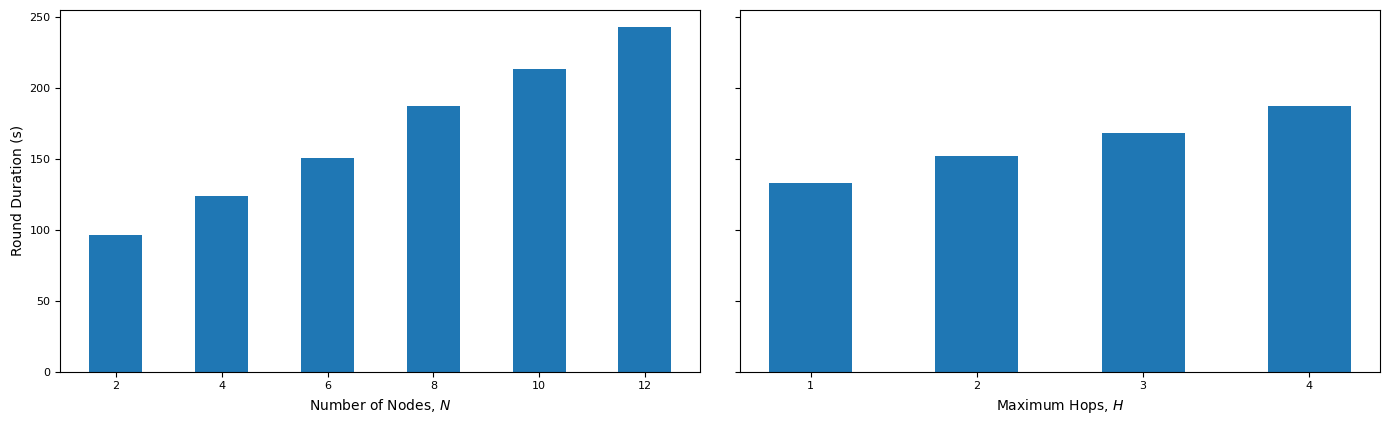

In [25]:
# CPU utilization per state (training, waiting, aggregating, broadcasting)
# y: Total CPU time per stage
# x:
#   - number of nodes       
#   - number of hops        

nr_nodes    = [2, 4, 6, 8, 10, 12]
nr_hops     = [1, 2, 3, 4]
outbox_size = [10 + (i) * 30 for i in range(6)]
def add_end_column(df):
    first_ts_per_value = (
        df[df['field'] == "total_sent"]
        .groupby(['node', 'value'])['timestamp']
        .min()
        .reset_index()
    )

    scenario_end_per_node = first_ts_per_value.groupby('node')['timestamp'].max()

    df['scenario_end'] = df['node'].map(scenario_end_per_node)

    # Keep rows where timestamp <= scenario_end
    filtered_df = df[df['timestamp'] <= df['scenario_end']].copy()

    return filtered_df

def get_total_mem(df):
    return df[df['field'] == "memory_mb"].groupby('node')['value'].mean().mean()

def get_total_cpu(df):
    return df[df['field'] == "cpu_total_ns"].groupby('node')['value'].max().mean()

def get_total_time(df):
    max_time = df.groupby('node')['timestamp'].max().max()
    start = df['timestamp'].min()                            
        
    delta = max_time - start                              
    return delta.total_seconds()   

def get_max_time(df):
    # max_time = df[(df['field'] == "current_round") & (df['value'] == 1.0)].groupby('node')['timestamp'].max().max() 
    df = df[df['field'] == 'total_sent'].sort_values(by='timestamp').drop_duplicates()
    max_time = df.groupby('node')['timestamp'].max().max() 
    return max_time

def convert_time(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')
    return df

def filter_time(df):
    max_time = get_max_time(df)
    filtered_df = df[df['timestamp'] <= max_time]
    return filtered_df

def stage_plot(ax, x_axis, x_name, folder, y_name, mode="cpu"):
    files = get_filenames_in_folder(join(metrics_path, folder))[:len(x_axis)]
    df_files = [add_end_column(convert_time(read_file(f))) for f in files]
    df_files = [filter_time(df) for df in df_files]

    if (mode=="cpu"):
        y_axis = [get_total_cpu(df) for df in df_files]
    elif (mode=="mem"):
        y_axis = [get_total_mem(df) for df in df_files]
    else:
        y_axis = [get_total_time(df) for df in df_files]

    data = np.array(y_axis)

    print(data)

    n = min(len(x_axis), len(y_axis))
    data = data[:n]
    x_axis = x_axis[:n]
    x = np.arange(len(x_axis))

    # Sum all stage values per x-axis point to get a single value
    ax.bar(x, data, width=0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(x_axis)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)

# ----------- CPU FIGURE -----------
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

stage_plot(axs[0], nr_nodes, "Number of Nodes, $N$", "nr_nodes", "CPU Time (s)")
stage_plot(axs[1], nr_hops[:4], "Maximum Hops, $H$", "max_hops", "CPU Time (s)")

fig.tight_layout(rect=[0, 0.03, 1, 0.90])
fig.savefig(join(figure_path, "cpu_per_stage_grid.png"))
axs[1].set_ylabel("")
plt.show()

# ----------- MEMORY FIGURE -----------
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

stage_plot(axs[0], nr_nodes, "Number of Nodes, $N$", "nr_nodes", "Memory MB", mode="mem")
stage_plot(axs[1], nr_hops[:4], "Maximum Hops, $H$", "max_hops", "Memory MB", mode="mem")

fig.tight_layout(rect=[0, 0.03, 1, 0.90])
fig.savefig(join(figure_path, "memory_per_stage_grid.png"))
axs[1].set_ylabel("")
plt.show()

# ----------- TIME FIGURE -----------
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

stage_plot(axs[0], nr_nodes, "Number of Nodes, $N$", "nr_nodes", "Round Duration (s)", mode="time")
stage_plot(axs[1], nr_hops[:4], "Maximum Hops, $H$", "max_hops", "Round Duration (s)", mode="time")

fig.tight_layout(rect=[0, 0.03, 1, 0.90])
fig.savefig(join(figure_path, "time_per_stage_grid.png"))
axs[1].set_ylabel("")
plt.show()

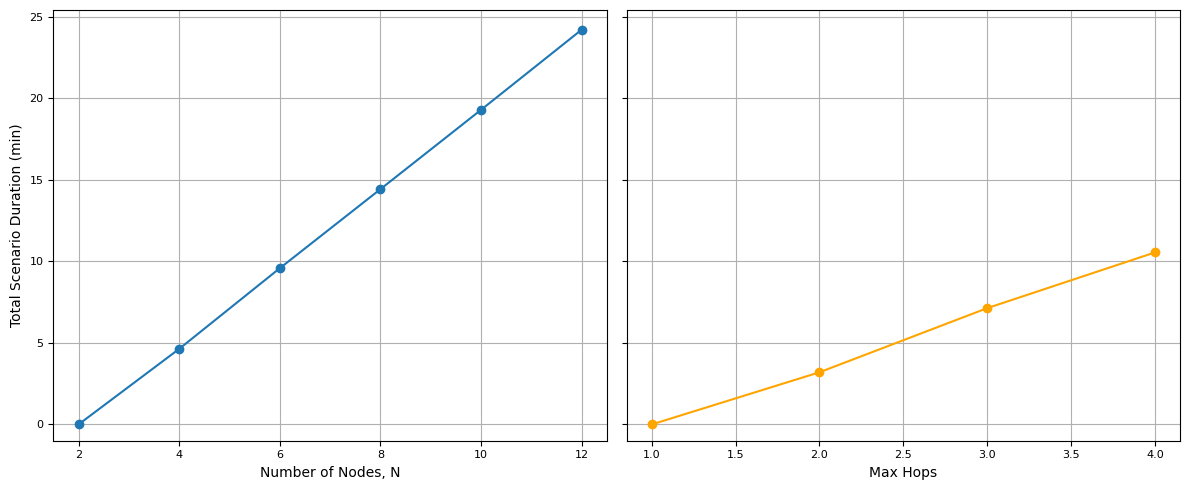

In [34]:
files_nodes = get_filenames_in_folder(join(metrics_path, "accuracy"))
df_files_nodes = [read_file(f) for f in files_nodes]

files_hops = get_filenames_in_folder(join(metrics_path, "max_hops_10_rounds"))
df_files_hops = [read_file(f) for f in files_hops]

def get_total_duration(df_files):
    y_axis = []
    for df in df_files:
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')

        df = df[df['field'] == 'total_sent'].sort_values(by='timestamp').drop_duplicates()
        max_time = df.groupby('node')['timestamp'].max().max() 
        start = df['timestamp'].min()
        
        delta = max_time - start
        y_axis.append(delta)

    y_axis_seconds = [
        (ts - y_axis[0]).total_seconds() if not pd.isna(ts) else None
        for ts in y_axis
    ]

    y_axis_minutes = [sec / 60 for sec in y_axis_seconds]

    return y_axis_minutes


y_axis_nodes = get_total_duration(df_files_nodes)
y_axis_hops = get_total_duration(df_files_hops)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # share y-axis

# First subplot: duration vs number of nodes
ax1.plot(nr_nodes, y_axis_nodes, marker='o')
ax1.set_xlabel("Number of Nodes, N")
ax1.set_ylabel("Total Scenario Duration (min)")
ax1.grid(True)
ax1.set_ylim(bottom=0)  # y-axis starts at 0

# Second subplot: duration vs max_hops
ax2.plot(nr_hops, y_axis_hops, marker='o', color='orange')
ax2.set_xlabel("Max Hops")
ax2.grid(True)
ax2.set_ylim(bottom=-1)  # same y-axis start, will sync due to sharey=True

plt.tight_layout()
plt.savefig("scenario_duration.png")
plt.show()

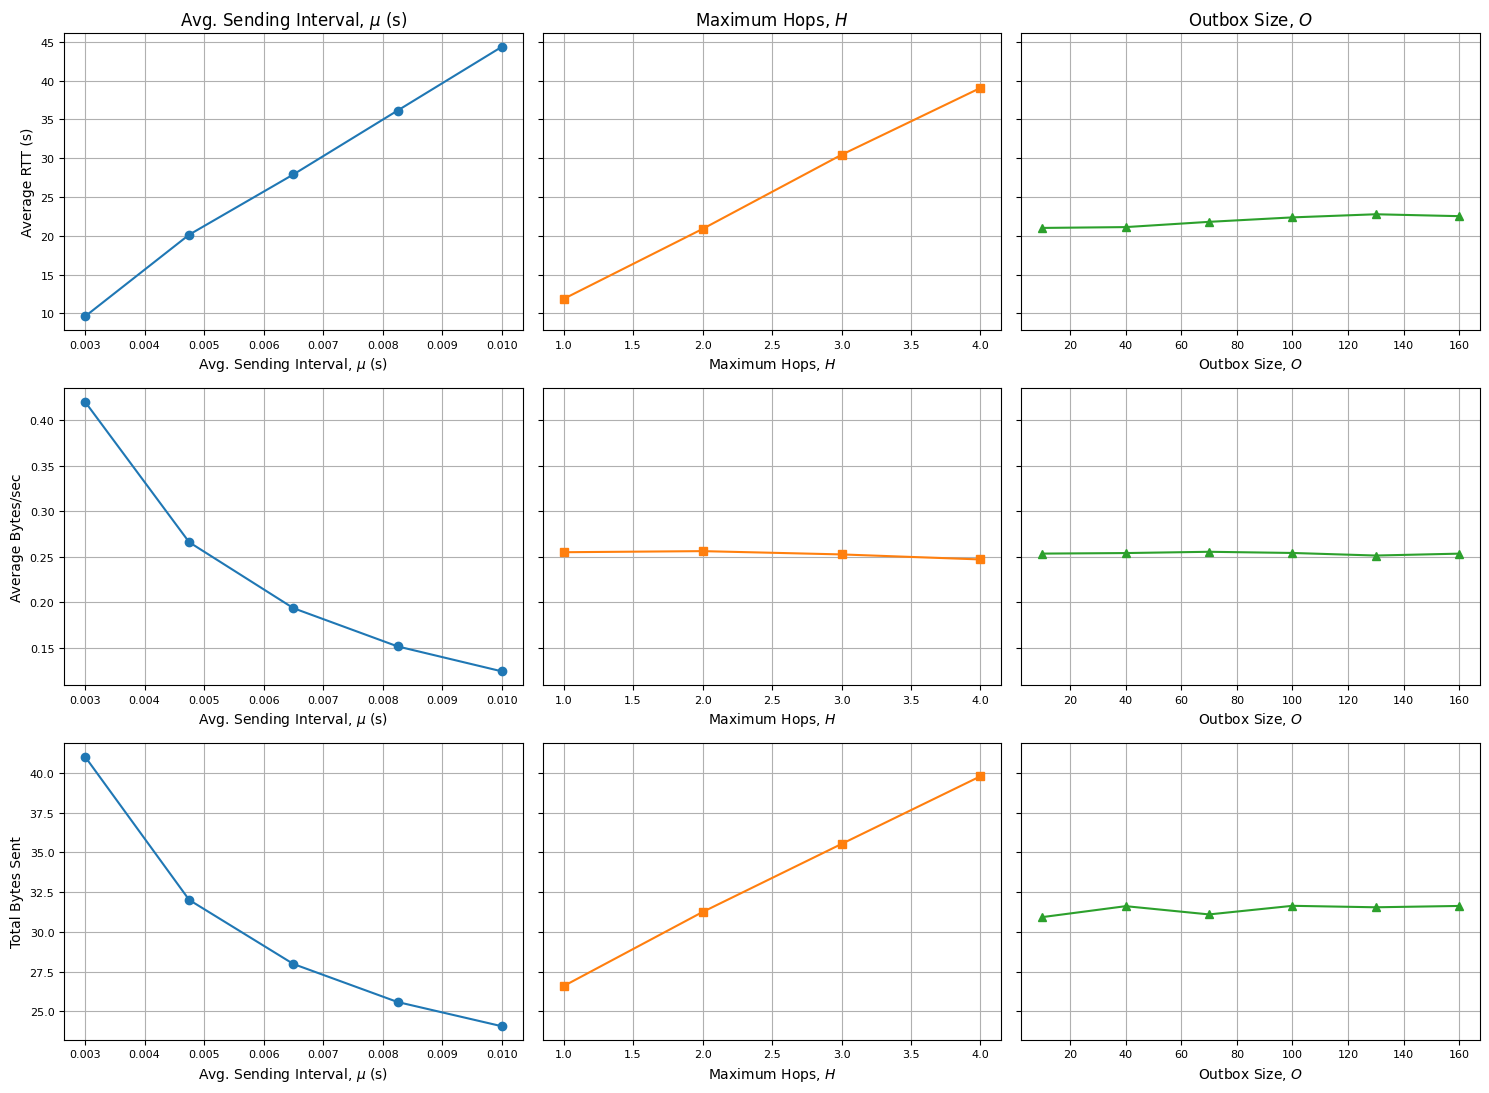

In [ ]:
# y: RTT
# x:
#   - delay in seconds
#   - number of hops

def get_avg_rtt(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')

    # max_peers = df[df['field'] == "active_peers"]["value"].max()
    # start, end = get_time_interval(df, "active_peers", max_peers)

    # df_interval = df[(df['timestamp'] > start) & (df['timestamp'] < end)]
    # df_interval = df
    rtt_per_node = df[(df['field'] == "last_rtt") & (df['value'] != 0)].groupby('node')
    mean_per_node = rtt_per_node['value'].apply(lambda x: x.unique().mean())
    mean = mean_per_node.mean()
    return mean

def plot_combined_rtt_and_bytes_single_figure(x_sets, x_labels, folders):
    fig, axs = plt.subplots(3, 3, figsize=(15, 12), sharey='row')
    markers = ['o', 's', '^']
    colors = ['tab:blue', 'tab:orange', 'tab:green']

    for i, (x_vals, xlabel, folder) in enumerate(zip(x_sets, x_labels, folders)):
        files = get_filenames_in_folder(join(metrics_path, folder))
        df_files = [read_file(f) for f in files]

        y_rtt = [get_avg_rtt(df) for df in df_files]
        rt_list = [get_duration(df) for df in df_files]
        y_total_bytes = np.array([get_total_msgbytes(df) for df in df_files])
        y_bytes_s = y_total_bytes / rt_list

        n = min(len(df_files), len(x_vals))
        x_vals = x_vals[:n]
        y_rtt = y_rtt[:n]
        y_bytes_s = y_bytes_s[:n]
        y_total_bytes = y_total_bytes[:n]

        axs[0, i].plot(x_vals, y_rtt, marker=markers[i], color=colors[i])
        axs[0, i].set_title(xlabel)
        axs[0, i].set_xlabel(xlabel)
        if i == 0:
            axs[0, i].set_ylabel("Average RTT (s)")
        axs[0, i].grid(True)

        axs[1, i].plot(x_vals, y_bytes_s, marker=markers[i], color=colors[i])
        axs[1, i].set_title("")
        axs[1, i].set_xlabel(xlabel)
        if i == 0:
            axs[1, i].set_ylabel("Average Bytes/sec")
        axs[1, i].grid(True)

        axs[2, i].plot(x_vals, y_total_bytes, marker=markers[i], color=colors[i])
        axs[2, i].set_title("")
        axs[2, i].set_xlabel(xlabel)
        if i == 0:
            axs[2, i].set_ylabel("Total Bytes Sent")
        axs[2, i].grid(True)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(join(figure_path, f"combined_metrics_rtt_bytes.png"))
    plt.show()


x_sets = [mus, nr_hops, outbox_size]
x_labels = ['Avg. Sending Interval, $\\mu$ (s)', "Maximum Hops, $H$", "Outbox Size, $O$"]
folders = ["run_time", "max_hops", "outbox_size"]

plot_combined_rtt_and_bytes_single_figure(x_sets, x_labels, folders)


The output rate of a node is solely determined by the average output rate parameter, therefore the curve is completely flat for max hops and otubox size

Therefore, total bytes increase with maximum hops and it decreases all the same with avg outbox interval, bc it controls the amount of cover traffic.

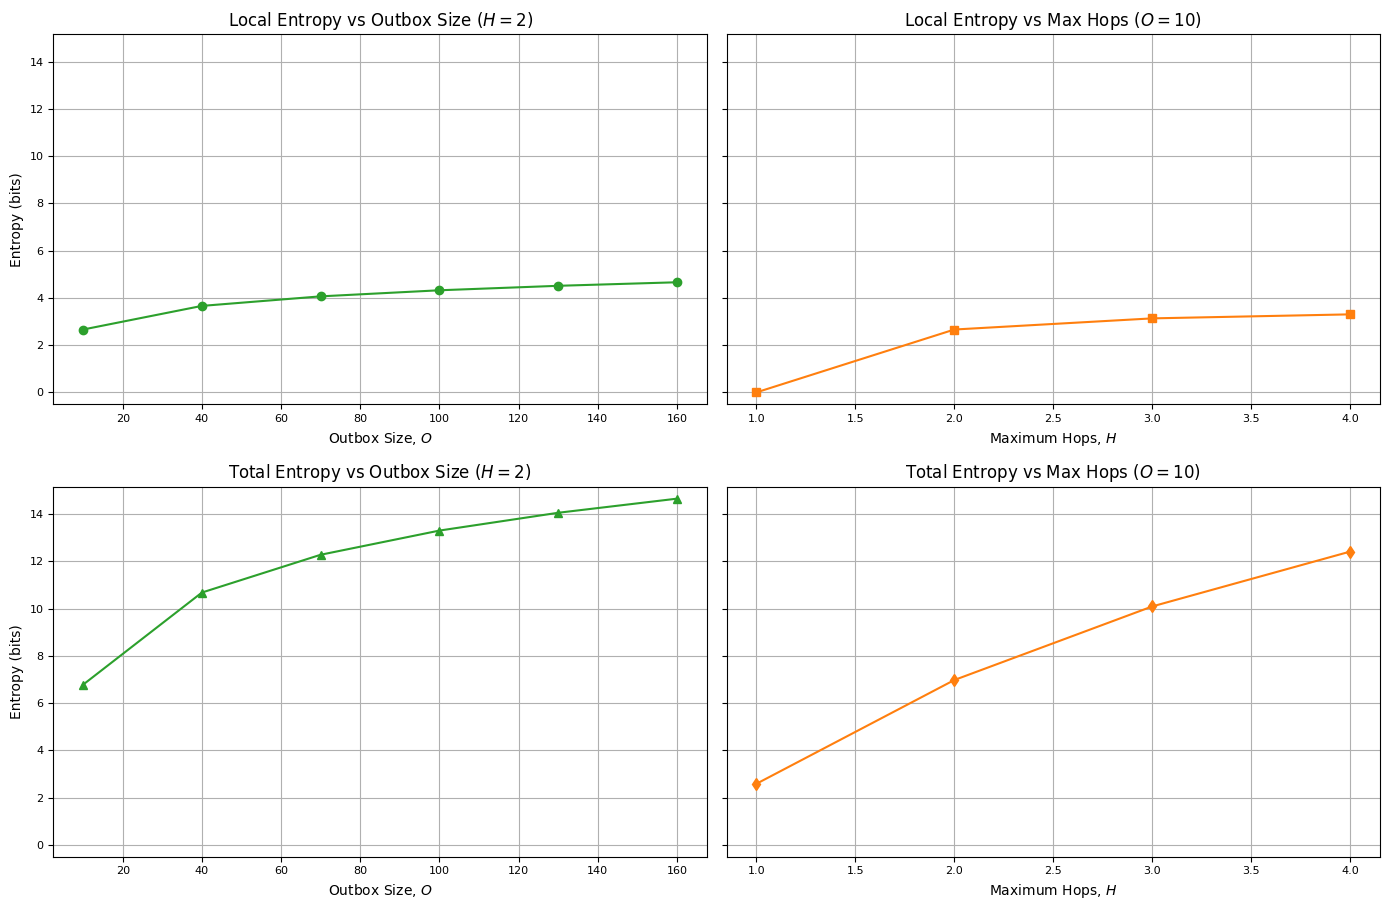

In [4]:
def entropy(probs):
    sum = 0
    for p in probs:
        sum += p * np.log2(p)
    return -sum

# the entropy of matching incoming message to outgoing message in a singular node
def entropy_in_out(outbox_size, max_hops):
    terminated = 1/max_hops
    relayed = 1 - terminated
    relayed_events = [relayed * 1/outbox_size] * outbox_size if relayed != 0 else []
    events = relayed_events + [terminated]
    return entropy(events)

# X e nodes - start node
# tracking a fragment to its recipient
def entropy_recipient(max_hops, nr_nodes):
    n_events = 0
    for hops in range(1, max_hops+1):
        n_per_hops = int(factorial(nr_nodes-1)/factorial(nr_nodes-1-max_hops))
        n_events += n_per_hops
    probs = [1/n_events] * n_events
    return entropy(probs)

def total_path_entropy(outbox_size, max_hops):
    n_events = 0
    for hops in range(1, max_hops+1):
        n_events += outbox_size**hops
    probs = [1/n_events] * n_events
    return entropy(probs)

y_e_io_outbox   = [entropy_in_out(outbox, 2) for outbox in outbox_size]
y_e_io_hops     = [entropy_in_out(10, hops) for hops in nr_hops]
y_e_total_hops    = [total_path_entropy(outbox, 2) for outbox in outbox_size]
y_e_total_nodes   = [total_path_entropy(hops, 6) for hops in nr_hops]

all_vals = y_e_io_outbox + y_e_io_hops + y_e_total_hops + y_e_total_nodes
max_y = max(all_vals) + 0.5
min_y = min(all_vals) - 0.5

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharey='row')
axs = axs.flatten()  # makes indexing easier (axs[0] to axs[3])

# Plot 1: entropy_path vs outbox_size (max_hops = 2)
axs[0].plot(outbox_size, y_e_io_outbox, marker='o', color='tab:green')
axs[0].set_title("Local Entropy vs Outbox Size ($H = 2$)")
axs[0].set_xlabel("Outbox Size, $O$")
axs[0].set_ylabel("Entropy (bits)")
axs[0].grid(True)
axs[0].set_ylim(min_y, max_y)

# Plot 2: entropy_path vs max_hops (outbox_size = 10)
axs[1].plot(nr_hops, y_e_io_hops, marker='s', color='tab:orange')
axs[1].set_title("Local Entropy vs Max Hops ($O = 10$)")
axs[1].set_xlabel("Maximum Hops, $H$")
axs[1].grid(True)
axs[1].set_ylim(min_y, max_y)

# Plot 3: entropy_recipient vs nr_nodes (max_hops = 2)
axs[2].plot(outbox_size, y_e_total_hops, marker='^', color='tab:green')
axs[2].set_title("Total Entropy vs Outbox Size ($H = 2$)")
axs[2].set_xlabel("Outbox Size, $O$")
axs[2].set_ylabel("Entropy (bits)")
axs[2].grid(True)
axs[2].set_ylim(min_y, max_y)

# Plot 4: entropy_recipient vs max_hops (nr_nodes = 6)
axs[3].plot(nr_hops, y_e_total_nodes, marker='d', color='tab:orange')
axs[3].set_title("Total Entropy vs Max Hops ($O = 10$)")
axs[3].set_xlabel("Maximum Hops, $H$")
axs[3].grid(True)
axs[3].set_ylim(min_y, max_y)

# Adjust layout and save
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig(join(figure_path, "entropy_combined_subplots.png"))
plt.show()


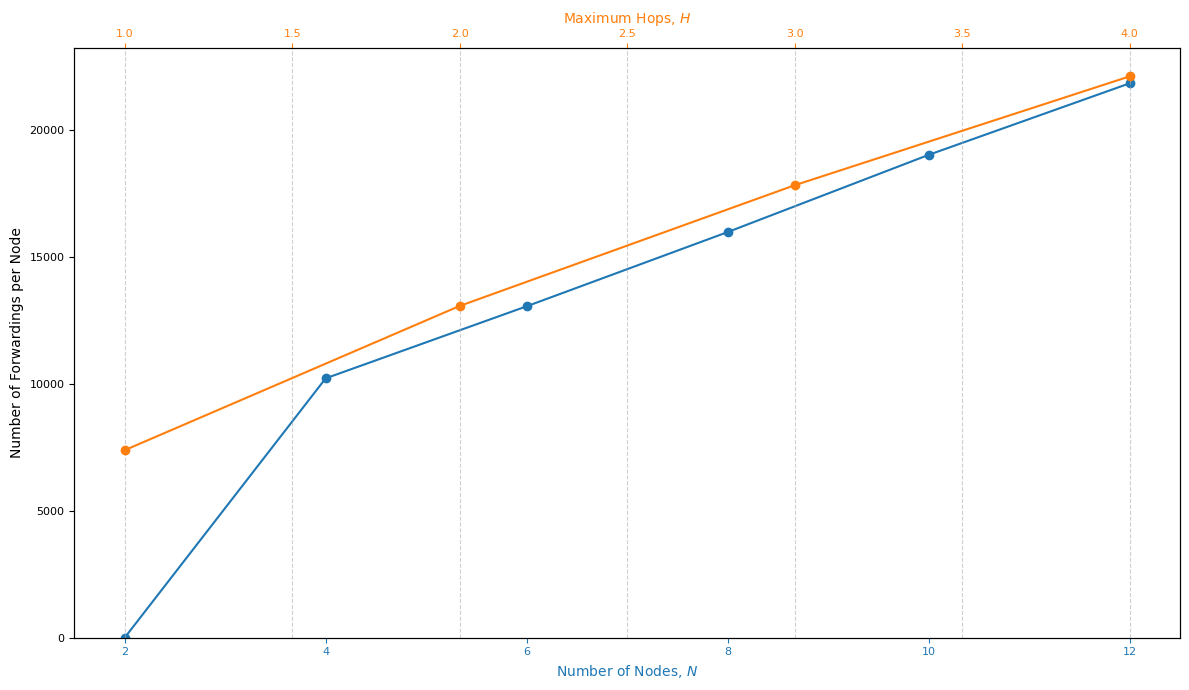

In [ ]:
def get_nr_forwardings(df):
    max_mean = df[df["field"] == "forwarded"].groupby("node")['value'].max().mean()
    return max_mean

def get_y_axis_values(folder):
    files = get_filenames_in_folder(join(metrics_path, folder))
    df_files = [read_file(f) for f in files]
    return [get_nr_forwardings(df) for df in df_files]

def plot_avg_forwardings(x_axis, y_axis, ax, xlabel, color):
    n = min(len(x_axis), len(y_axis))
    x_axis, y_axis = x_axis[:n], y_axis[:n]
    ax.plot(x_axis, y_axis, marker='o', color=color, label=xlabel)
    ax.set_xlabel(xlabel, color=color)
    ax.set_ylabel("# forwardings per node")
    ax.tick_params(axis='x', colors=color)

y_nodes = get_y_axis_values("nr_nodes")
y_hops = get_y_axis_values("max_hops")

fig, ax1 = plt.subplots(figsize=FIGURE_SIZE)

plot_avg_forwardings(nr_nodes, y_nodes, ax1, "Number of Nodes, $N$", color='tab:blue')
ax1.set_ylabel("Number of Forwardings per Node")
ax1.set_ylim(bottom=0, top=max(max(y_nodes), max(y_hops)) * 1.05)

ax2 = ax1.twiny()
plot_avg_forwardings(nr_hops[:4], y_hops, ax2, "Maximum Hops, $H$", color='tab:orange')

fig.tight_layout()
plt.grid(True, axis='y')
plt.savefig(join(figure_path, "nr_forwardings.png"))
plt.grid(**GRID_STYLE)
plt.show()


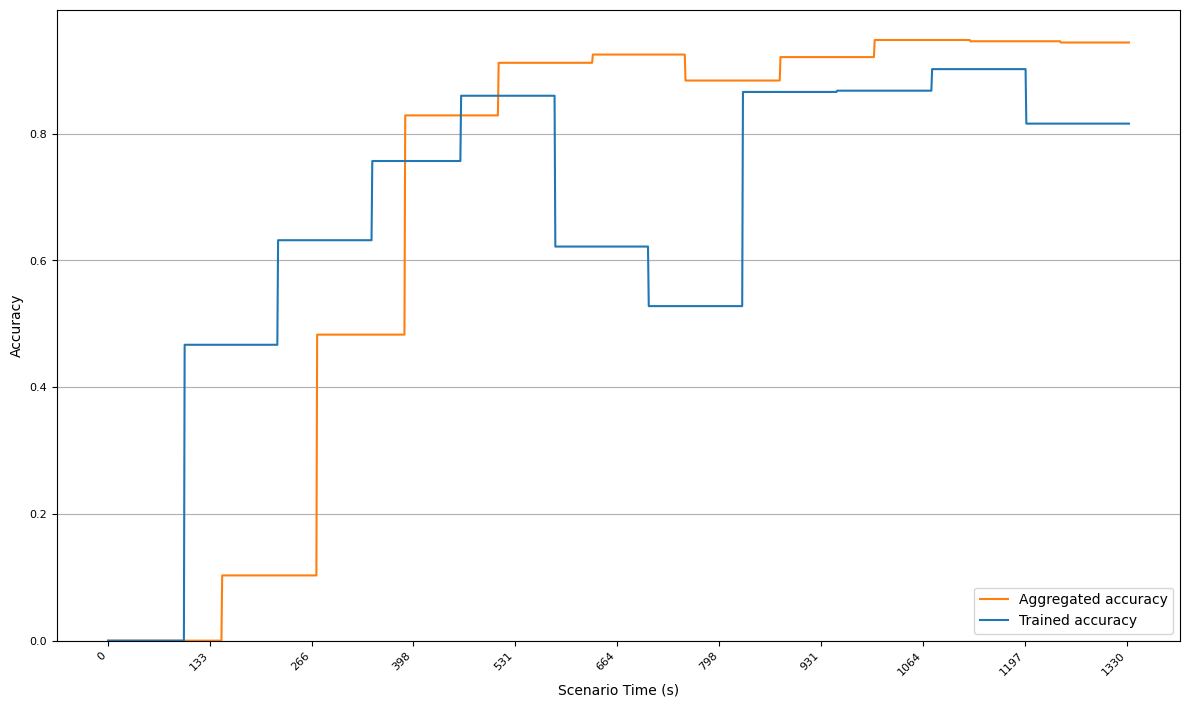

In [9]:
def plot_acc(node):
    filename = get_filenames_in_folder(join(metrics_path, "accuracy"))[2]
    df = read_file(filename)

    timestamps = df[(df['node'] == node) & (df['field'] == 'aggregated_accuracy')]['timestamp']
    timestamps = pd.to_datetime(timestamps)

    # Convert to seconds starting at 0
    x_axis = (timestamps - timestamps.min()).dt.total_seconds()

    agg_acc = df[(df['node'] == node) & (df['field'] == 'aggregated_accuracy')]['value']
    acc = df[(df['node'] == node) & (df['field'] == 'accuracy')]['value']

    fig, ax = plt.subplots(figsize=FIGURE_SIZE)

    ax.plot(x_axis, agg_acc, color='tab:orange', label="Aggregated accuracy")
    ax.plot(x_axis, acc, color='tab:blue', label="Trained accuracy")

    ax.set_xlabel("Scenario Time (s)")
    ax.set_ylabel("Accuracy")
    ax.set_ylim(bottom=0, top=max(max(agg_acc), max(acc)) * 1.05)

    step = max(1, len(x_axis) // 10)
    ax.set_xticks(x_axis[::step])

    ax.legend(loc="lower right")

    fig.tight_layout()
    plt.grid(True, axis='y')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.savefig(join(figure_path, "agg_accuracy.png"))
    plt.show()

plot_acc('node_0')
    


[0.9495     0.9075     0.80166667 0.819      0.7822     0.7585    ]


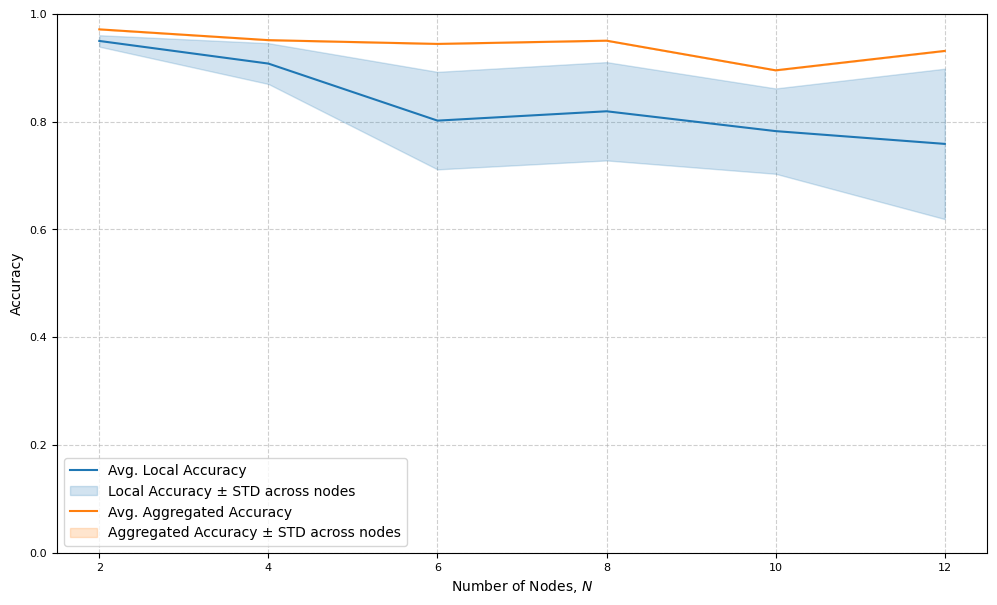

In [ ]:
plt.figure(figsize=FIGURE_SIZE)

files = get_filenames_in_folder(join(metrics_path, "accuracy"))
dfs = [read_file(f) for f in files]

def get_attr_per_node(df, attr):
    return df[df['field'] == attr].groupby('node').tail(1)['value']

local_mean = np.array([get_attr_per_node(df, 'accuracy').mean() for df in dfs])
local_std = np.array([get_attr_per_node(df, 'accuracy').std() for df in dfs])
global_mean = np.array([get_attr_per_node(df, 'aggregated_accuracy').mean() for df in dfs])
global_std = np.array([get_attr_per_node(df, 'aggregated_accuracy').std() for df in dfs])

print(local_mean)

plt.plot(nr_nodes, local_mean, color="tab:blue", label="Avg. Local Accuracy")
plt.fill_between(
    nr_nodes,
    local_mean - local_std,
    local_mean + local_std,
    color="tab:blue",
    alpha=0.2,
    label="Local Accuracy ± STD across nodes"
)

plt.plot(nr_nodes, global_mean, color="tab:orange", label="Avg. Aggregated Accuracy")
plt.fill_between(
    nr_nodes,
    global_mean - global_std,
    global_mean + global_std,
    color="tab:orange",
    alpha=0.2,
    label="Aggregated Accuracy ± STD across nodes"
)

plt.ylim(0, 1)
fig.tight_layout()
plt.ylabel("Accuracy")
plt.xlabel("Number of Nodes, $N$")
plt.legend()
plt.grid(**GRID_STYLE)
plt.savefig(join(figure_path, "accuracy_by_nodes.png"))
plt.show()